In [ ]:
!pip uninstall qiskit
!pip install numpy==0.19.5
!pip install qiskit==0.24
#!pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src
!pip install pylatexenc

In [1]:
import qiskit
token = '3c648969b4c49d2521944ea0c52d2466348ca185619f2d642d3d12fc3caeb0118c0ac3724f078a784a4e81192decacad79a85d7503a27324ca880e00b2b61662'
qiskit.IBMQ.save_account(token)
account = qiskit.IBMQ.load_account()
provider = qiskit.IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_qasm_simulator')
print(provider, backend)

configrc.store_credentials:WARNING:2022-09-05 09:01:31,870: Credentials already present. Set overwrite=True to overwrite.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')> ibmq_qasm_simulator


In [2]:
from qiskit import execute
from qiskit.circuit import Parameter,ControlledGate
from qiskit import Aer
import qiskit
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Running on the GPU")
else:
  device = torch.device("cpu")
  print("Running on the CPU")

Running on the GPU


In [3]:
#np.random.seed = 314

NUM_QUBITS = 4
NUM_SHOTS = 800 #3000
SHIFT = np.pi/4
LEARNING_RATE = 0.0002
MOMENTUM = 0.5

try:
    SIMULATOR = Aer.get_backend('qasm_simulator')
except:
    
    print("QiskitBackendNotFoundError: 'No backend matches the criteria'")
    
    available_cloud_backends = account.backends() 
    print('\nHere is the list of cloud backends that are available to you:')
    for i in available_cloud_backends: print(i)

    available_local_backends = Aer.backends() 
    print('\nHere is the list of local backends that are available to you: ')
    for i in available_local_backends: print(i)

In [4]:
# create list of all possible outputs of quantum circuit (2**NUM_QUBITS possible)
import itertools
def create_QC_OUTPUTS():
    measurements = list(itertools.product([0, 1], repeat=NUM_QUBITS))
    return [''.join([str(bit) for bit in measurement]) for measurement in measurements]

QC_OUTPUTS = create_QC_OUTPUTS()
print(QC_OUTPUTS)

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']


# Circuit

In [5]:
class QiskitCircuit():
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self.circuit = qiskit.QuantumCircuit(n_qubits)
        self.n_qubits = n_qubits
        self.thetas = {k : Parameter('Theta'+str(k))for k in range(2*self.n_qubits)}
        
        all_qubits = [i for i in range(n_qubits)]
        self.circuit.h(all_qubits)
        self.circuit.barrier()

        #self.circuit.h(0)

        for k in range(0, 4):
          self.circuit.ry(self.thetas[k], k)

        self.circuit.cx(1, 0)
        self.circuit.cx(2, 0)
        self.circuit.cx(3, 0)
        self.circuit.cx(2, 1)
        self.circuit.cx(3, 1)
        self.circuit.cx(3, 2)

        for k in range(0, 4):
          self.circuit.ry(self.thetas[k+4], k)

        self.circuit.measure_all()
        # ---------------------------
        
        self.backend = backend
        self.shots = shots
        
        
    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expects = np.zeros(len(QC_OUTPUTS))
        for k in range(len(QC_OUTPUTS)):
            key = QC_OUTPUTS[k]
            perc = counts.get(key, 0)/shots
            expects[k] = perc
        return expects
    
    def run(self, i):
        params = i
        #print('params = {}'.format(len(params)))
        backend = Aer.get_backend('qasm_simulator')
    
        job_sim = execute(self.circuit,
                              self.backend,
                              shots=self.shots,
                              parameter_binds = [{self.thetas[k] : params[k].item() for k in range(2*NUM_QUBITS)}])
#         
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        return self.N_qubit_expectation_Z(counts, self.shots, NUM_QUBITS)

/opt/conda/lib/python3.8/site-packages/qiskit/circuit/tools/pi_check.py:49: SymPyDeprecationWarning: 

The expr_free_symbols property is deprecated. Use free_symbols to get
the free symbols of an expression.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-expr-free-symbols
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  syms = inpt._symbol_expr.expr_free_symbols


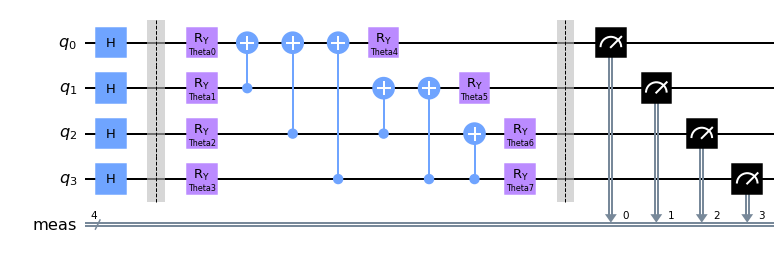

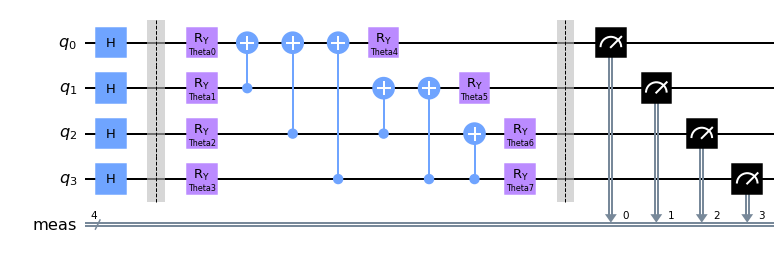

In [6]:
circuit = QiskitCircuit(NUM_QUBITS, SIMULATOR, NUM_SHOTS)
#print('Expected value for rotation [pi/4]: {}'.format(circuit.run(torch.Tensor([np.pi/4]*NUM_QUBITS))))
circuit.circuit.draw(output='mpl')#, filename='Figures/{}-qubit circuit ryN.jpg'.format(NUM_QUBITS)

In [7]:
class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)
            
        exp_value = ctx.QiskitCirc.run(i)
        
        result = torch.tensor([exp_value], device = device)
  
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        
        forward_tensor, i = ctx.saved_tensors
#         print('forward_tensor = {}'.format(forward_tensor))
        input_numbers = i
#         print('input_numbers = {}'.format(input_numbers))
        gradients = torch.Tensor().to(device)
        
        for k in range(2*NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT
            
#             print('shift_right = {}, shift_left = {}'.format(shift_right, shift_left))
            
            expectation_right = ctx.QiskitCirc.run(shift_right)
            expectation_left  = ctx.QiskitCirc.run(shift_left)
#             print('expectation_right = {}, \nexpectation_left = {}'.format(expectation_right, expectation_left))
            
            gradient = torch.tensor([expectation_right], device = device) - torch.tensor([expectation_left], device = device)
            # rescale gradient
#             gradient = gradient / torch.norm(gradient)
#             print('gradient for k={}: {}'.format(k, gradient))
            gradients = torch.cat((gradients, gradient.float()))
            
        result = gradients.detach().clone()
#         print('gradients = {}'.format(result))
#         print('grad_output = {}'.format(grad_output))

        return (result.float() * grad_output.float()).T

In [8]:
import sys
sys.path.append('/home/jovyan/QNN4RadarImage/')

In [9]:
from DatasetHandler import DatasetHandler
dataset_root = '/home/jovyan/QNN4RadarImage/datasets/EuroSAT/'
handler = DatasetHandler(dataset_root)

In [10]:
classes = []
for i, c in enumerate(handler.classes):
  cl = c.split('/')[-1]
  classes.append(cl)
classes.sort()
classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [11]:
imgs_path, imgs_label = handler.load_paths_labels(dataset_root, classes=classes)
print('Dataset images:', len(imgs_path), 'Dataset labels:', len(imgs_label))
print('Dataset sample ->', imgs_path[0], imgs_label[0])

Dataset images: 27000 Dataset labels: 27000
Dataset sample -> /home/jovyan/QNN4RadarImage/datasets/EuroSAT/Pasture/Pasture_403.jpg 5


In [12]:
train_imgs, train_labels, val_images, val_labels = handler.train_validation_split(imgs_path, imgs_label, split_factor=0.2)
print('X_train shape:', train_imgs.shape, 'Y_train shape:', train_labels.shape)
print('  X_val shape: ', val_images.shape, '  Y_val shape: ', val_labels.shape)

X_train shape: (21600,) Y_train shape: (21600,)
  X_val shape:  (5400,)   Y_val shape:  (5400,)


In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)

        #self.conv2_drop = nn.Dropout2d()

        self.fc1 = nn.Linear(2304, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 42)

        self.fc4 = nn.Linear(2304, 2*NUM_QUBITS)
        
        self.qc = TorchCircuit.apply

        self.fc5 = nn.Linear(16, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))

        x = x.view(-1, 2304)
        #x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        #x = F.relu(self.fc2(x))

        #x = F.relu(self.fc3(x))

        x = self.fc4(x)
        x = np.pi*torch.tanh(x)
        
        x = self.qc(x[0]) # QUANTUM LAYER
        
        x = F.relu(x)
        #print('output of QC = {}'.format(x))
        
#         # softmax rather than sigmoid
        x = self.fc5(x.float())
        #print('output of Linear(1, 2): {}'.format(x))
        x = F.softmax(x, 1)

        #x = torch.sigmoid(x)
        #x = torch.cat((x, 1-x), -1)
        return x
    
    
    def predict(self, x):
        # apply softmax
        pred = self.forward(x)
#         print(pred)
        ans = torch.argmax(pred[0]).item()
        return torch.tensor(ans, device = device)
    
network = Net().to(device)
optimizer = optim.Adam(network.parameters(), lr=0.0002)

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

#from torchsummary import summary
#summary(network, (3, 64, 64))

In [15]:
train_loader = iter(handler.qcnn_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,3)))
test_loader = iter(handler.qcnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))

In [16]:
checkpoint = torch.load('/home/jovyan/QNN4RadarImage/JSTARS2021/quantum_classifiers/eurosat_classification/saved_models/model-real-amp-2.pt', map_location=device)
network.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [18]:
train_loss_list = []
val_loss_list = []
epochs = 25

loss_func = nn.CrossEntropyLoss()

for epoch in range(epochs):
  train_loader = iter(handler.qcnn_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,3)))
  test_loader = iter(handler.qcnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))
  total_loss = []
  for batch_idx in range(len(train_labels)):
    data, target = next(train_loader) 
    data = data.to(device)
    target = target.to(device)
    # print(batch_idx)
    optimizer.zero_grad()        
    # Forward pass
    output = network(data)
    # Calculating loss
    loss = loss_func(output, target)
    # Backward pass
    loss.backward()
    loss.detach_()
    
    # Optimize the weights
    optimizer.step()
    
    total_loss.append(loss.item())
    
    print('\r Epoch %d ~ Batch %d (%d) ~ Loss %f ' % (epoch, batch_idx, len(train_imgs)-1, loss.item()), end='\t\t')
    
    del output
    del loss
  
  with torch.no_grad():
    val_loss = []
    targets = []
    predictions = []
    for batch_idx in range(len(val_images)):
      data, target = next(test_loader)
      data = data.to(device)
      target = target.to(device)
      output = network(data)
      loss = loss_func(output, target)
      loss.detach_()
      val_loss.append(loss.item())
        
      del output
      del loss

      targets.append(target.item())
      
      predictions.append(network.predict(data).item())
  
      
  train_loss_list.append(sum(total_loss)/len(total_loss))
  val_loss_list.append(sum(val_loss)/len(val_loss))
  
  print('Training [{:.0f}%]\t Training Loss: {:.4f} Validation Loss: {:.4f}'.format(
      100. * (epoch + 1) / epochs, train_loss_list[-1], val_loss_list[-1]))
  
  if epoch % 3 == 1:
    print(confusion_matrix(targets, predictions,normalize='true'))
    print(classification_report(targets, predictions, target_names=classes, digits=4))
    torch.save({
            'epoch': epoch,
            'model_state_dict': network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss_list[-1],
            }, '/home/jovyan/QNN4RadarImage/JSTARS2021/quantum_classifiers/eurosat_classification/saved_models_new/model-real-amp-2.pt')
    #torch.save(network.state_dict(), '/content/drive/MyDrive/QAI4EO/model-bell.pt')

 Epoch 0 ~ Batch 21599 (21599) ~ Loss 1.461209 		Training [4%]	 Training Loss: 1.5338 Validation Loss: 1.5643
 Epoch 1 ~ Batch 21599 (21599) ~ Loss 1.461166 		Training [8%]	 Training Loss: 1.5295 Validation Loss: 1.5657
[[0.86511628 0.00465116 0.0124031  0.02945736 0.         0.01085271
  0.02790698 0.00310078 0.04496124 0.00155039]
 [0.         0.98313659 0.01349073 0.00168634 0.         0.00168634
  0.         0.         0.         0.        ]
 [0.01145038 0.0019084  0.89503817 0.02862595 0.00763359 0.01526718
  0.01908397 0.01526718 0.0019084  0.00381679]
 [0.01028807 0.00205761 0.01646091 0.81893004 0.02057613 0.01646091
  0.03703704 0.01646091 0.0617284  0.        ]
 [0.         0.         0.         0.0039604  0.93861386 0.
  0.0019802  0.04554455 0.00990099 0.        ]
 [0.00229358 0.0733945  0.02752294 0.01146789 0.         0.80045872
  0.01605505 0.02522936 0.04357798 0.        ]
 [0.01176471 0.         0.09019608 0.06078431 0.00196078 0.00588235
  0.81764706 0.00784314 0.0039

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 4 ~ Batch 20290 (21599) ~ Loss 1.461157 		

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 5 ~ Batch 1891 (21599) ~ Loss 2.409777 		

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 6 ~ Batch 10794 (21599) ~ Loss 1.461282 		

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 6 ~ Batch 13998 (21599) ~ Loss 1.461165 		

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 7 ~ Batch 21599 (21599) ~ Loss 1.461160 		Training [32%]	 Training Loss: 1.5200 Validation Loss: 1.5860
[[0.93867925 0.00157233 0.00471698 0.00314465 0.00471698 0.00786164
  0.00628931 0.00157233 0.02515723 0.00628931]
 [0.         0.96984127 0.01904762 0.0015873  0.         0.0047619
  0.         0.         0.0015873  0.0031746 ]
 [0.02333333 0.00333333 0.895      0.02333333 0.00166667 0.01666667
  0.01       0.01       0.         0.01666667]
 [0.05668016 0.00202429 0.05870445 0.71862348 0.02226721 0.01012146
  0.048583   0.00607287 0.0708502  0.00607287]
 [0.00393701 0.         0.01574803 0.00984252 0.8484252  0.
  0.01771654 0.08858268 0.01574803 0.        ]
 [0.00697674 0.03488372 0.0372093  0.01860465 0.         0.85813953
  0.00465116 0.01395349 0.0255814  0.        ]
 [0.07592191 0.0021692  0.18004338 0.02169197 0.00433839 0.0021692
  0.70281996 0.0021692  0.00867679 0.        ]
 [0.         0.         0.00509338 0.         0.         0.
  0.         0.99490662 0.        

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 8 ~ Batch 4629 (21599) ~ Loss 1.462512 		

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 9 ~ Batch 14725 (21599) ~ Loss 1.828065 		

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 10 ~ Batch 21599 (21599) ~ Loss 1.461391 		Training [44%]	 Training Loss: 1.5177 Validation Loss: 1.5855
[[0.89984351 0.00312989 0.00469484 0.01408451 0.         0.00312989
  0.00625978 0.         0.0657277  0.00312989]
 [0.00494234 0.93080725 0.01812191 0.00329489 0.         0.00658979
  0.         0.         0.00988468 0.02635914]
 [0.         0.         0.87275986 0.0483871  0.01612903 0.02508961
  0.02150538 0.00358423 0.00896057 0.00358423]
 [0.03877551 0.         0.01836735 0.76530612 0.01428571 0.
  0.03265306 0.00816327 0.12244898 0.        ]
 [0.00811359 0.00608519 0.         0.02434077 0.92900609 0.
  0.02028398 0.00608519 0.00608519 0.        ]
 [0.01123596 0.02022472 0.02022472 0.02022472 0.         0.8247191
  0.00674157 0.00224719 0.08988764 0.00449438]
 [0.05954825 0.00205339 0.07186858 0.10677618 0.00205339 0.01232033
  0.73305955 0.         0.01232033 0.        ]
 [0.         0.         0.00160514 0.01284109 0.0529695  0.
  0.00481541 0.92776886 0.         0.   

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 12 ~ Batch 15949 (21599) ~ Loss 1.483175 		

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 13 ~ Batch 21599 (21599) ~ Loss 1.462392 		Training [56%]	 Training Loss: 1.5123 Validation Loss: 1.5705
[[0.90228013 0.00325733 0.00977199 0.00651466 0.00325733 0.00488599
  0.0276873  0.         0.03908795 0.00325733]
 [0.         0.95198675 0.01821192 0.00165563 0.         0.01821192
  0.         0.         0.00165563 0.00827815]
 [0.01417323 0.0015748  0.87244094 0.02047244 0.01732283 0.01574803
  0.0519685  0.00314961 0.00314961 0.        ]
 [0.03483607 0.         0.03278689 0.76229508 0.01639344 0.00409836
  0.06147541 0.00614754 0.08196721 0.        ]
 [0.         0.         0.00574713 0.01724138 0.94252874 0.
  0.00383142 0.02490421 0.00574713 0.        ]
 [0.00694444 0.0162037  0.03240741 0.         0.         0.8912037
  0.01157407 0.00694444 0.03009259 0.00462963]
 [0.02586207 0.         0.09698276 0.03017241 0.00646552 0.01077586
  0.82112069 0.         0.00862069 0.        ]
 [0.         0.         0.00527241 0.00351494 0.01581722 0.
  0.01405975 0.96133568 0.      

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 15 ~ Batch 15953 (21599) ~ Loss 1.461152 		

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 16 ~ Batch 21599 (21599) ~ Loss 1.461612 		Training [68%]	 Training Loss: 1.5117 Validation Loss: 1.5817
[[0.87579618 0.00318471 0.01910828 0.01433121 0.00318471 0.03025478
  0.02866242 0.         0.02070064 0.00477707]
 [0.         0.977813   0.         0.00158479 0.         0.00950872
  0.         0.         0.00475436 0.00633914]
 [0.01655629 0.00165563 0.86754967 0.02317881 0.00165563 0.02317881
  0.05298013 0.00993377 0.00331126 0.        ]
 [0.01836735 0.00204082 0.02244898 0.81020408 0.02040816 0.0122449
  0.04897959 0.00612245 0.05918367 0.        ]
 [0.         0.         0.003861   0.02702703 0.88610039 0.
  0.03088803 0.03861004 0.01351351 0.        ]
 [0.         0.00945626 0.03782506 0.01654846 0.         0.89361702
  0.00236407 0.0141844  0.02364066 0.00236407]
 [0.03769841 0.00198413 0.11706349 0.04563492 0.00198413 0.01984127
  0.76984127 0.         0.00595238 0.        ]
 [0.         0.         0.00715564 0.00894454 0.01788909 0.
  0.01252236 0.94812165 0.005366

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 17 ~ Batch 5876 (21599) ~ Loss 2.444714 		

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 18 ~ Batch 11174 (21599) ~ Loss 1.461173 		

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 18 ~ Batch 16497 (21599) ~ Loss 1.461490 		

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 19 ~ Batch 21599 (21599) ~ Loss 1.527880 		Training [80%]	 Training Loss: 1.5079 Validation Loss: 1.5766
[[0.89984351 0.00782473 0.00782473 0.02347418 0.         0.00625978
  0.02034429 0.         0.0312989  0.00312989]
 [0.         0.96740995 0.00343053 0.01372213 0.0051458  0.0051458
  0.         0.         0.         0.0051458 ]
 [0.0214168  0.00988468 0.84019769 0.00823723 0.01153213 0.01317957
  0.08731466 0.00658979 0.00164745 0.        ]
 [0.04618474 0.         0.02008032 0.81526104 0.01606426 0.00200803
  0.04216867 0.00200803 0.0562249  0.        ]
 [0.         0.         0.00821355 0.01232033 0.9650924  0.
  0.00410678 0.01026694 0.         0.        ]
 [0.01165501 0.08624709 0.01631702 0.06293706 0.         0.7972028
  0.01165501 0.         0.01398601 0.        ]
 [0.04564315 0.00207469 0.05394191 0.04771784 0.02282158 0.00829876
  0.80912863 0.         0.01037344 0.        ]
 [0.         0.         0.00536673 0.00536673 0.03935599 0.
  0.         0.94991055 0.       

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 20 ~ Batch 21599 (21599) ~ Loss 1.461156 		Training [84%]	 Training Loss: 1.5070 Validation Loss: 1.5851
 Epoch 21 ~ Batch 21599 (21599) ~ Loss 1.461154 		Training [88%]	 Training Loss: 1.5085 Validation Loss: 1.5861
 Epoch 22 ~ Batch 21599 (21599) ~ Loss 2.458476 		Training [92%]	 Training Loss: 1.5062 Validation Loss: 1.5787
[[0.86271186 0.00338983 0.01016949 0.02881356 0.00169492 0.01016949
  0.03220339 0.         0.04576271 0.00508475]
 [0.         0.96463023 0.01607717 0.00643087 0.         0.00160772
  0.         0.         0.00482315 0.00643087]
 [0.00168067 0.00504202 0.85378151 0.02352941 0.01680672 0.02184874
  0.05882353 0.01176471 0.00672269 0.        ]
 [0.02879079 0.         0.03454894 0.73704415 0.04990403 0.00767754
  0.05182342 0.00767754 0.0806142  0.00191939]
 [0.         0.         0.00808081 0.0040404  0.96969697 0.
  0.00606061 0.01010101 0.0020202  0.        ]
 [0.0046729  0.0864486  0.01869159 0.02102804 0.         0.82476636
  0.00233645 0.         0.042

In [ ]:
fig, plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.title('Hybrid NN Training Convergence for {}-qubit'.format(NUM_QUBITS))
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')
plt.legend(['Training', 'Validation'])
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
  return a * np.exp(-b * x) + c

x = np.linspace(0,len(train_loss_list),len(train_loss_list))
y = func(x, 2.5, 1.3, 0.5)
yn = np.array(val_loss_list)

popt, pcov = curve_fit(func, x, yn)

plt.figure()
x1 = np.linspace(0,100+len(train_loss_list),100+len(train_loss_list))
plt.plot(x, yn, 'ko', label="Loss")
plt.plot(x1, func(x1, *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()

In [ ]:
test_loader = iter(handler.qcnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))
accuracy = 0
number = 0

predictions = []
targets = []

for ct in range(len(val_images)):

  data, target = next(test_loader)
  data = data.to(device)
  target = target.to(device)
  number +=1
  output = network.predict(data).item()
  
  predictions.append(output)
  targets.append(target.item())
  
  accuracy += (output == target[0].item())*1
  print('\r ' + str(ct), end='')

In [ ]:
plt.hist(targets, bins = 10)

In [ ]:
print("Performance on test data is : {}/{} = {}%".format(accuracy,number,100*accuracy/number))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
cm = confusion_matrix(targets, predictions,normalize='true')

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (12,10))

cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
cmd.plot(ax=axes, cmap='Blues', xticks_rotation='vertical')
print('S2')
print('Accuracy:', cm.diagonal(), 'mean: ', cm.diagonal().mean())
print(classification_report(targets, predictions, target_names=classes, digits=4))
axes.get_images()[0].set_clim(0, 1)
plt.show()
plt.close()